# Implementing LSTM

Using Fake news classifier

# 1)- Import Key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hassan.sherwani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# 2- Loading and preparing data

- Dataset: https://www.kaggle.com/c/fake-news/data#

In [4]:
df=pd.read_csv('train.csv')
df.shape

(20800, 5)

In [5]:
df.head(3)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1


In [6]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
###Drop Nan Values
df=df.dropna()
df.shape

(18285, 5)

In [8]:
df.to_csv('ready_data.csv', index=0)

In [9]:
df=pd.read_csv('ready_data.csv')
df.shape

(18285, 5)

In [10]:
## Get the Independent Features

X=df[['title']]

In [11]:
## Get the Dependent features
y=df['label']

In [12]:
print(X.shape)
print(y.shape)

(18285, 1)
(18285,)


### 2.1.Corpus building

In [13]:
titles=X.copy()

In [14]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(titles)):
    review = re.sub('[^a-zA-Z]', ' ', titles['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [15]:
corpus[:5]

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri']

### 2.2.One_hot encoding

In [16]:
### Vocabulary size
voc_size=5000
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr[:5]

[[3195, 3819, 4115, 1834, 2587, 4313, 130, 3405, 2223, 4196],
 [1470, 1467, 3099, 2281, 16, 74, 116],
 [729, 1932, 358, 1021],
 [3298, 4722, 4900, 3569, 2532, 3155],
 [3655, 16, 3521, 4383, 4492, 696, 16, 907, 397, 1049]]

[hous dem aid even see comey letter jason chaffetz tweet] is encoded as

[2620, 3271, 469, 1972, 4408, 2180, 4327, 2937, 2257, 2824]

### 2.3.Embedding Representation

In [17]:
#padding
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs[:5])

[[   0    0    0    0    0    0    0    0    0    0 3195 3819 4115 1834
  2587 4313  130 3405 2223 4196]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0 1470
  1467 3099 2281   16   74  116]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0  729 1932  358 1021]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
  3298 4722 4900 3569 2532 3155]
 [   0    0    0    0    0    0    0    0    0    0 3655   16 3521 4383
  4492  696   16  907  397 1049]]


Notice that sentence lenth is 20 and our 1st sentence has 10 words. So all other words are padded as zeros.

# 3- Model

In [18]:
embedding_vector_features=40 # dimension of embedding layer
voc_size=5000
sent_length=20
output_layer= 1 
epochs=10
batch_size=64

### 3.1. Defining basic model architecture

In [19]:
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100)) # one lstm layer with 100 neurons
model.add(Dense(output_layer,activation='sigmoid'))

In [20]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


##### Summary params calculation

https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

**There are three steps:**

- For embedding layer: Dim of embedded layer(40) * vocab_size(5000)

- For LSTM Layer: Now formula is **#of params=g*[h(h+i)+biase]**

where g=lstm layer length i.e 1. For FFNS, RNN has 1 , LSTM has 4 and GRU has 3 layers<br>
h=hidden layer size (number of neurons in hidden layer) i.e 100<br> 
i=Input size/dimension i.e embedding_vector_features that is coming as an input on lstm layer in step2 (40 is value) <br>
biase= 100 of neurons for outpt of lstm layer

**4*[100(100+40)+100]**

- For Dense (Output): lstm layer acting as input(100) * neurons in output layer(1) + biase(1 as there is only one neuron in output layer)

In [22]:
len(embedded_docs),y.shape

(18285, (18285,))

In [23]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [24]:
print(X_final.shape)
print(y_final.shape)

(18285, 20)
(18285,)


### 3.2.split train_test

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)

### 3.3.Model Training

In [26]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size)

Train on 14628 samples, validate on 3657 samples
Epoch 1/10
14628/14628 [==============================] - 6s 395us/sample - loss: 0.3134 - accuracy: 0.8558 - val_loss: 0.2000 - val_accuracy: 0.9073
Epoch 2/10
14628/14628 [==============================] - 3s 237us/sample - loss: 0.1365 - accuracy: 0.9476 - val_loss: 0.2090 - val_accuracy: 0.9111
Epoch 3/10
14628/14628 [==============================] - 3s 233us/sample - loss: 0.1004 - accuracy: 0.9645 - val_loss: 0.2174 - val_accuracy: 0.9139
Epoch 4/10
14628/14628 [==============================] - 3s 237us/sample - loss: 0.0761 - accuracy: 0.9716 - val_loss: 0.2724 - val_accuracy: 0.9136
Epoch 5/10
14628/14628 [==============================] - 3s 236us/sample - loss: 0.0548 - accuracy: 0.9815 - val_loss: 0.2842 - val_accuracy: 0.9103
Epoch 6/10
14628/14628 [==============================] - 3s 237us/sample - loss: 0.0386 - accuracy: 0.9882 - val_loss: 0.3406 - val_accuracy: 0.9141
Epoch 7/10
14628/14628 [===========================

### 3.4. evaluate model

In [27]:
y_pred=model.predict_classes(X_test)
y_pred[:5]

array([[1],
       [0],
       [0],
       [0],
       [1]])

In [28]:
confusion_matrix(y_test,y_pred)

array([[1864,  218],
       [ 100, 1475]], dtype=int64)

In [29]:
accuracy_score(y_test,y_pred)

0.9130434782608695

### 3.5.adding dropout

results are sligtly improved

In [30]:
from tensorflow.keras.layers import Dropout
## Creating model
embedding_vector_features=40
model_dropout=Sequential()
model_dropout.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model_dropout.add(Dropout(0.3))
model_dropout.add(LSTM(100))
model_dropout.add(Dropout(0.3))
model_dropout.add(Dense(1,activation='sigmoid'))
model_dropout.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model_dropout.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
model_dropout.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size)

Train on 14628 samples, validate on 3657 samples
Epoch 1/10
14628/14628 [==============================] - 6s 395us/sample - loss: 0.3130 - accuracy: 0.8536 - val_loss: 0.2012 - val_accuracy: 0.9103
Epoch 2/10
14628/14628 [==============================] - 3s 237us/sample - loss: 0.1437 - accuracy: 0.9442 - val_loss: 0.1955 - val_accuracy: 0.9122
Epoch 3/10
14628/14628 [==============================] - 3s 234us/sample - loss: 0.1076 - accuracy: 0.9607 - val_loss: 0.2070 - val_accuracy: 0.9161
Epoch 4/10
14628/14628 [==============================] - 4s 239us/sample - loss: 0.0864 - accuracy: 0.9677 - val_loss: 0.2238 - val_accuracy: 0.9144
Epoch 5/10
14628/14628 [==============================] - 3s 235us/sample - loss: 0.0661 - accuracy: 0.9769 - val_loss: 0.2855 - val_accuracy: 0.9171
Epoch 6/10
14628/14628 [==============================] - 3s 238us/sample - loss: 0.0543 - accuracy: 0.9806 - val_loss: 0.2931 - val_accuracy: 0.9163
Epoch 7/10
14628/14628 [===========================

In [32]:
y_pred=model_dropout.predict_classes(X_test)
y_pred[:5]

array([[1],
       [0],
       [0],
       [0],
       [1]])

In [33]:
accuracy_score(y_test,y_pred)

0.9179655455291222

### 3.6.Using EarlyStopping

In [43]:
from keras.callbacks import EarlyStopping

In [44]:
%%time
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test,y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 14628 samples, validate on 3657 samples
Epoch 1/10
14628/14628 [==============================] - 3s 232us/sample - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.5029 - val_accuracy: 0.9103
Epoch 2/10
14628/14628 [==============================] - 3s 232us/sample - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.6246 - val_accuracy: 0.9046
Epoch 3/10
14628/14628 [==============================] - 3s 235us/sample - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.5204 - val_accuracy: 0.9070
Epoch 4/10
14628/14628 [==============================] - 3s 234us/sample - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.7130 - val_accuracy: 0.9119
Wall time: 13.7 s


In [45]:
y_pred=model.predict_classes(X_test)
y_pred[:5]

array([[1],
       [0],
       [0],
       [0],
       [1]])

In [46]:
accuracy_score(y_test,y_pred)

0.9119496855345912

In [47]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2082
           1       0.89      0.91      0.90      1575

    accuracy                           0.91      3657
   macro avg       0.91      0.91      0.91      3657
weighted avg       0.91      0.91      0.91      3657



In [48]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[1901  181]
 [ 141 1434]]


Populating the interactive namespace from numpy and matplotlib


<Figure size 720x720 with 0 Axes>

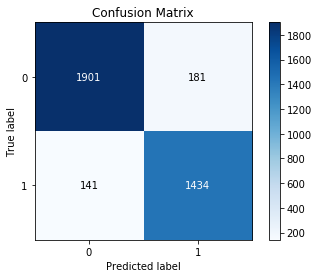

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import scikitplot as skplt
plt.figure(figsize=(10,10))
skplt.metrics.plot_confusion_matrix(y_test,y_pred)
plt.show()